# Theano 实例：Logistic 回归

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

Using gpu device 0: GeForce GTX 850M


## sigmoid 函数

一个 `logistic` 曲线由 `sigmoid` 函数给出：
$$s(x) = \frac{1}{1+e^{-x}}$$

我们来定义一个 `elementwise` 的 sigmoid 函数：

In [2]:
x = T.matrix('x')
s = 1 / (1 + T.exp(-x))
sigmoid = theano.function([x], s, allow_input_downcast=True)

这里 `allow_input_downcast=True` 的作用是允许输入 `downcast` 成定义的输入类型：

In [3]:
sigmoid([[ 0, 1],
         [-1,-2]])

array([[ 0.5       ,  0.7310586 ],
       [ 0.26894143,  0.11920293]], dtype=float32)

其图像如下所示：

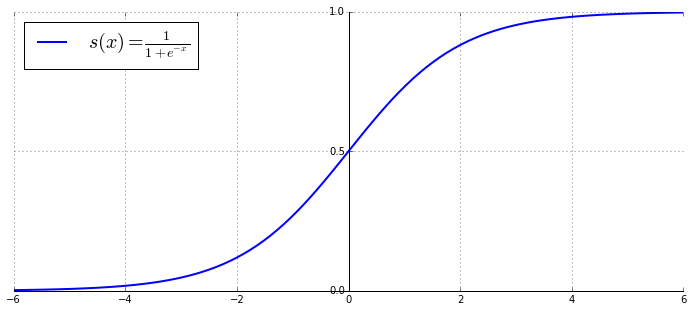

In [4]:
X = np.linspace(-6, 6, 100)
X = X[np.newaxis,:]

plt.figure(figsize=(12,5))

plt.plot(X.flatten(), sigmoid(X).flatten(), linewidth=2)

# 美化图像的操作
#=========================
plt.grid('on')
plt.yticks([0,0.5,1])

ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))

plt.legend([r'$s(x)=\frac{1}{1+e^{-x}}$'], loc=0, fontsize=20)
#=========================

plt.show()

## sigmoid 函数与 tanh 函数的关系

`sigmoid` 函数与 `tanh` 之间有如下的转化关系：
$$s(x)=\frac{1}{1+e^{-x}}=\frac{1+\tanh(x/2)}{2}$$

In [5]:
s2 = (1 + T.tanh(x / 2)) / 2

sigmoid2 = theano.function([x], s2)

sigmoid2([[ 0, 1],
          [-1,-2]])

array([[ 0.5       ,  0.7310586 ],
       [ 0.26894143,  0.11920291]], dtype=float32)

## logistic 回归

简单的二元逻辑回归问题可以这样描述：我们要对数据点 $x = (x_1, ..., x_n)$ 进行 0-1 分类，参数为 $w = (w_1, ..., w_n), b$，我们的假设函数如下：

$$
\begin{align}
h_{w,b}(x) & = P(Y=1|X=x) \\
& = sigmoid(z) \\
& =\frac{1}{1 + e^{-z}}\\
\end{align}
$$

其中

$$
\begin{align}
z & = x_1w_1 + ... + x_nw_n + b\\
& = w^T x + b\\
\end{align}
$$

对于一个数据点 $(x, y), y\in \{0,1\}$ 来说，我们的目标是希望 $h_{w,b}(x)$ 的值尽量接近于 $y$。

由于数值在 0-1 之间，我们用交叉熵来衡量 $h_{w,b}(x)$ 和 $y$ 的差异：

$$- y \log(h_{w,b}(x)) - (1-y) \log(1-h_{w,b}(x))$$

对于一组数据，我们定义损失函数为所有差异的均值，然后通过梯度下降法来优化损失函数，得到最优的参数 $w, b$。

## 实例

生成随机数据：

In [6]:
rng = np.random

# 数据大小和规模
N = 400
feats = 784

# D = (X, Y)
D = (rng.randn(N, feats), rng.randint(size=N, low=0, high=2))

定义 `theano` 变量：

In [7]:
x = T.matrix('x')
y = T.vector('y')

# 要更新的变量：
w = theano.shared(rng.randn(feats), name='w')
b = theano.shared(0., name='b')

定义模型：

In [8]:
h = 1 / (1 + T.exp(-T.dot(x, w) - b))

当 $h > 0.5$ 时，认为该类的标签为 1：

In [9]:
prediction = h > 0.5

损失函数和梯度：

In [10]:
cost = - T.mean(y * T.log(h) + (1 - y) * T.log(1 - h)) + 0.01 * T.sum(w ** 2)  # 正则项，防止过拟合
gw, gb = T.grad(cost, [w, b])

编译训练和预测函数：

In [11]:
train = theano.function(inputs=[x, y],
                        outputs=cost,
                        updates=[[w, w - 0.1 * gw], [b, b - 0.1 * gb]], 
                        allow_input_downcast=True)

predict = theano.function(inputs=[x],
                          outputs=prediction,
                          allow_input_downcast=True)

In [12]:
for i in xrange(10001):
    err = train(D[0], D[1])
    if i % 1000 == 0:
        print 'iter %5d, error %f' % (i, err)

iter     0, error 19.295896
iter  1000, error 0.210341
iter  2000, error 0.126124
iter  3000, error 0.124872
iter  4000, error 0.124846
iter  5000, error 0.124845
iter  6000, error 0.124845
iter  7000, error 0.124845
iter  8000, error 0.124845
iter  9000, error 0.124845
iter 10000, error 0.124845


查看结果：

In [13]:
print D[1]

[0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0
 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0
 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0
 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1
 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1
 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0
 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1
 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1
 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1
 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0]


In [14]:
print predict(D[0])

[0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0
 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0
 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0
 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1
 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1
 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0
 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1
 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1
 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1
 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0]
